In [2]:
!pip install requests --quiet
!pip install beautifulsoup4  --quiet
!pip install transformers --quiet
!pip install openai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 452.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 10.4 MB/s eta 0:00:00


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

import openai
import math
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')


from transformers import BartTokenizer, BartForConditionalGeneration
openai.api_key = ""

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [54]:
def get_reviews(url):
    user_agent = ({'User-Agent':
			'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
			AppleWebKit/537.36 (KHTML, like Gecko) \
			Chrome/90.0.4430.212 Safari/537.36',
			'Accept-Language': 'en-US, en;q=0.5'})
    page = requests.get(url, headers = user_agent)
    soup = BeautifulSoup(page.text, 'html.parser')

    reviews = []
    for review in soup.find_all('div', class_='review-container'):
        rating = review.find('span', class_='ui_bubble_rating')['class'][1].split('_')[-1]
        #title = review.find('div', class_='quote').text.strip()
        content = review.find('div', class_='entry').find('p').text.strip()
        #date = review.find('span', class_='ratingDate')['title']
        reviews.append({
            'rating': rating,
            #'title': title,
            'content': content,
            #'date': date
        })
    next_page_link = soup.find('a', class_='nav next ui_button primary')
    if next_page_link:
        next_page_url = 'https://www.tripadvisor.com' + next_page_link['href']
        # Recursively call the function to get reviews from the next page
        reviews += get_reviews(next_page_url)    
    return reviews


In [58]:
reviews=get_reviews("https://www.tripadvisor.com/Restaurant_Review-g294207-d17847946-Reviews-INTI_A_Nikkei_Experience-Nairobi.html")


In [56]:
def create_dataframe(data):
    df = pd.DataFrame(data, columns=['rating', 'content'])
    df['rating'] = df['rating'].astype(int) / 10
    return df.rename(columns={'content': 'review'})


In [59]:
reviews_df=create_dataframe(reviews)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  1386 non-null   float64
 1   review  1386 non-null   object 
dtypes: float64(1), object(1)
memory usage: 21.8+ KB


In [9]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]|[\d]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)
    # Join the tokens back into a string
    text = ' '.join(tokens)

    return text


In [60]:
reviews_df['review'] = reviews_df['review'].apply(preprocess_text)
reviews_df['review']

0       love the vibe and the atmosphere the food was ...
1       really nice service and good food very nice se...
2       great service by wycliffe good food and drinks...
3       great place service was delightful thank you m...
4       sumptuous food n best service from susan best ...
                              ...                        
1381    the location and view are great the interior s...
1382    this place is amazing the food is excellent th...
1383    if you are into peruvian and japanese cuisine ...
1384    food is delicious and vegetarian friendly the ...
1385    i am still trying to figure out why a restaura...
Name: review, Length: 1386, dtype: object

In [11]:
def sentiment_analysis(texts):
    # Load pre-trained sentiment analysis pipeline
    classifier = pipeline('sentiment-analysis')
    
    # Run sentiment analysis on input texts
    results = classifier(texts)
    
    return results

In [61]:
# Get sentiment predictions for reviews in DataFrame
sentiments = sentiment_analysis(reviews_df['review'].tolist())

# Add sentiment predictions to DataFrame
reviews_df['sentiment'] = [result['label'] for result in sentiments]
reviews_df['confidence'] = [result['score'] for result in sentiments]

# Get summary of sentiment predictions
summary = reviews_df['sentiment'].value_counts()


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [62]:
summary

POSITIVE    1311
NEGATIVE      75
Name: sentiment, dtype: int64

In [14]:
reviews_df

,rating,review,sentiment,confidence
0,5.0,servers jacob judy and peris made my entire fa...,POSITIVE,0.999763
1,2.0,in post pandemic world the menu offering is po...,NEGATIVE,0.999536
2,1.0,booked for a dinner when we came no more foods...,NEGATIVE,0.998128
3,5.0,the lamb was amazing thank you corazon douglas...,POSITIVE,0.999771
4,5.0,the food was amazing and the restaurant has a ...,POSITIVE,0.999887
...,...,...,...,...
99,5.0,i completely enjoyed the awesome ambience of s...,POSITIVE,0.999573
100,4.0,i eat here every time i come to nairobi certai...,POSITIVE,0.999747
101,4.0,great restuarant in the crowne plaza hotel fin...,POSITIVE,0.993810
102,5.0,i have been to sikia on multiple occasions and...,POSITIVE,0.999631


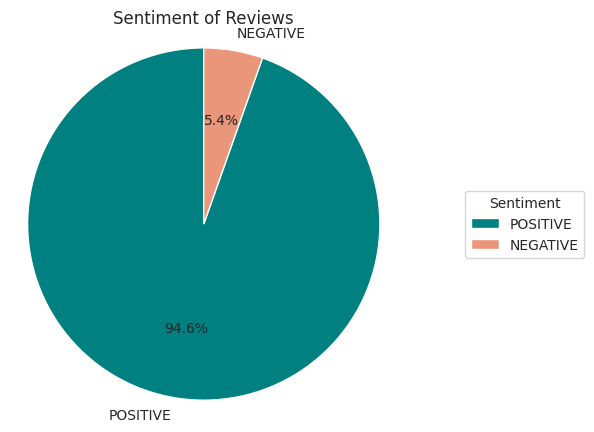

In [63]:

# Count the number of reviews with each sentiment
summary = reviews_df['sentiment'].value_counts()

# Create a pie chart using seaborn
sns.set_style("whitegrid")
sns.color_palette("pastel")
plt.figure(figsize=(5,5))
plt.title('Sentiment of Reviews')
plt.pie(summary, labels=summary.index, autopct='%1.1f%%', startangle=90, colors=['#008080', '#E9967A'])
plt.axis('equal')

# Add legend
plt.legend(title="Sentiment", loc="center right", bbox_to_anchor=(1, 0, 0.5, 1))

# Show the chart
plt.show()


In [70]:
negative_reviews = reviews_df[reviews_df['sentiment']=='NEGATIVE']['review'].tolist()
def generate_summary(text_list):

    # Define prompt for GPT-3
    prompt = (f"I have text containing negative reviews: {text_list}. Can you summarize them?")
    
    # Use OpenAI's GPT-3 to generate solutions based on input text
    response = openai.Completion.create( model="text-davinci-003", prompt=prompt, max_tokens=500,temperature=0)
    
    # Extract the generated text from the API response
    solution = response.choices[0].text.strip()
    
    return solution

In [71]:
summary = generate_summary(negative_reviews)

In [72]:
summary

'The reviews for Inti are generally negative, with customers citing poor service, expensive prices, and lack of attention to detail. Many customers also complained about the loud music, lack of access for disabled customers, and lack of response to emails or phone calls. The food was generally praised, but customers felt that the portions were too small and the prices too high.'

In [40]:
def generate_solution( text_list):

    # Define prompt for GPT-3
    prompt = (f"I have a variable containing negative reviews: {text_list}. Can you recommend a solution?")
    
    # Use OpenAI's GPT-3 to generate solutions based on input text
    response = openai.Completion.create( model="text-davinci-003", prompt=prompt, max_tokens=1024,temperature=0)
    
    # Extract the generated text from the API response
    solution = response.choices[0].text.strip()
    
    return solution


In [73]:
recommendation = generate_solution(summary)
recommendation

'A possible solution to the negative reviews for Inti could be to focus on customer service. This could include providing better customer service training for staff, responding to emails and phone calls in a timely manner, and making sure that the restaurant is accessible for disabled customers. Additionally, the restaurant could consider lowering prices and increasing portion sizes to make the food more affordable and satisfying. Finally, the restaurant could look into ways to reduce the noise level in the restaurant, such as using soundproofing materials or playing softer music.'